<a href="https://colab.research.google.com/github/Harshita-Puthran/Projects/blob/main/Bias_Drift_Detection_and_Fairness_Monitoring_in_Loan_Approval_Models_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fairlearn==0.10.0


In [2]:
!pip install -U matplotlib scikit-learn


In [3]:
!pip install mlflow

  Using cached mlflow-3.5.1-py3-none-any.whl.metadata (30 kB)
  Using cached mlflow_skinny-3.5.1-py3-none-any.whl.metadata (31 kB)
  Using cached mlflow_tracing-3.5.1-py3-none-any.whl.metadata (19 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 749.8/749.8 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 9.1 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, chi2_contingency, entropy, wasserstein_distance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate
import mlflow, mlflow.sklearn
import joblib
import os, json
sns.set(style="whitegrid")

In [5]:
df = pd.read_csv("loan_data.csv")
df.head(5)

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [6]:
categorical_features = ['person_gender','person_education','person_home_ownership',
                        'loan_intent','previous_loan_defaults_on_file']

numeric_features = ['person_age','person_income','person_emp_exp','loan_amnt',
                    'loan_int_rate','loan_percent_income','cb_person_cred_hist_length','credit_score']

target = 'loan_status'

X = df[categorical_features + numeric_features]
y = df[target]

In [7]:
df = df.drop_duplicates()


In [8]:
df['person_age'] = df['person_age'].astype(int).astype(int)
df['person_gender'] = df['person_gender'].astype(str)
df['person_emp_exp'] = df['person_emp_exp'].astype(int)
df['loan_status'] = df['loan_status'].astype(str)
df['previous_loan_defaults_on_file'] = df['previous_loan_defaults_on_file'].astype(str)

In [9]:
# Clip income between 15k and 150k
df['person_income'] = df['person_income'].clip(15000,150000)

# Clip loan amount between 1k and 40k
df['loan_amnt'] = df['loan_amnt'].clip(1000,40000)


In [10]:
df['person_gender'] = df['person_gender'].str.lower()
df['person_home_ownership'] = df['person_home_ownership'].str.upper()

In [11]:
# Feature engineering (age buckets and credit categories)
def engineer(df):
    df = df.copy()
    if 'person_age' in df.columns:
        bins = [0,25,35,50,65,200]
        labels = ['<25','25-34','35-49','50-64','65+']
        df['age_bucket'] = pd.cut(df['person_age'], bins=bins, labels=labels).astype(str)
    if 'credit_score' in df.columns:
        bins = [0,580,670,740,800,1000]
        labels = ['poor','fair','good','very_good','excellent']
        df['credit_score_cat'] = pd.cut(df['credit_score'], bins=bins, labels=labels).astype(str)
    return df

df_fe = engineer(df)

In [12]:
# Label Encoding for categorical features
from sklearn.preprocessing import LabelEncoder
cat_cols = ['person_gender','person_education','person_home_ownership',
            'loan_intent','previous_loan_defaults_on_file']
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Standard scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_cols = ['person_age','person_income','person_emp_exp','loan_amnt',
            'loan_int_rate','loan_percent_income','cb_person_cred_hist_length','credit_score']
df[num_cols] = scaler.fit_transform(df[num_cols])

print("✅ Data preprocessing completed!")

✅ Data preprocessing completed!


In [13]:
from sklearn.model_selection import train_test_split

# Assuming 'df_fe' is your preprocessed DataFrame with engineered features
train_df, test_df = train_test_split(df_fe, test_size=0.2, random_state=42)

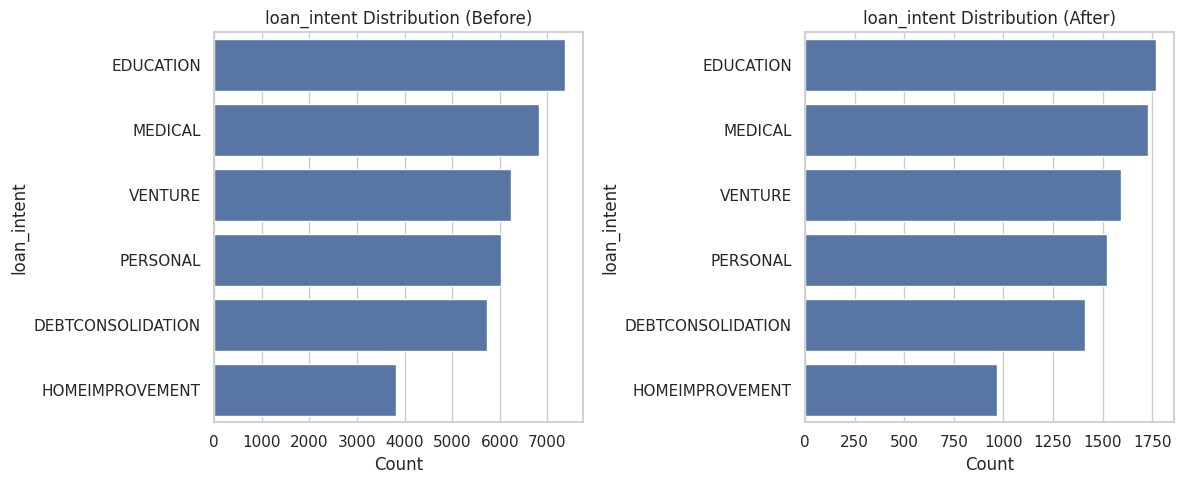

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def compare_textual_feature(train_df, test_df, feature):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.countplot(y=train_df[feature], order=train_df[feature].value_counts().index, ax=axes[0])
    axes[0].set_title(f'{feature} Distribution (Before)')
    axes[0].set_xlabel('Count')

    sns.countplot(y=test_df[feature], order=test_df[feature].value_counts().index, ax=axes[1])
    axes[1].set_title(f'{feature} Distribution (After)')
    axes[1].set_xlabel('Count')

    plt.tight_layout()
    plt.show()

# Example usage
compare_textual_feature(train_df, test_df, 'loan_intent')


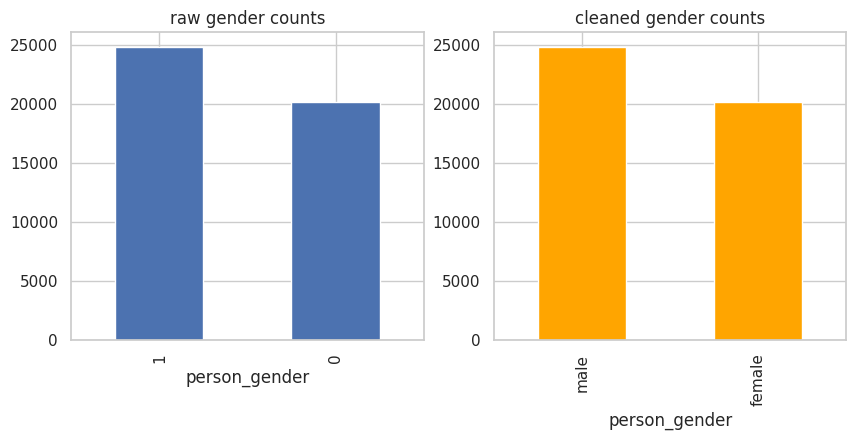

In [15]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
df['person_gender'].value_counts().plot(kind='bar', title='raw gender counts')
plt.subplot(1,2,2)
df_fe['person_gender'].value_counts().plot(kind='bar', title='cleaned gender counts', color='orange')
plt.show()

**Drift detection**

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from sklearn.preprocessing import LabelEncoder

# 🟦 Step 1: Split your preprocessed dataset into "reference" (old) and "current" (new)
# You can simulate drift by splitting 70/30
reference_df = df.sample(frac=0.7, random_state=42)
current_df = df.drop(reference_df.index)

# 🟦 Step 2: Function to calculate drift score per column
def calculate_drift(reference_df, current_df):
    drift_results = []

    for col in df.columns:
        if df[col].dtype == 'object':
            # Encode categorical
            le = LabelEncoder()
            ref = le.fit_transform(reference_df[col].astype(str))
            cur = le.transform(current_df[col].astype(str))
        else:
            ref = reference_df[col].dropna()
            cur = current_df[col].dropna()

            # Perform KS-test for numerical data
        ks_stat, p_value = ks_2samp(ref, cur)
        drift_detected = p_value < 0.05  # significant drift if p < 0.05
        drift_results.append({
            'feature': col,
            'ks_stat': round(ks_stat, 3),
            'p_value': round(p_value, 5),
            'drift_detected': drift_detected
        })

    return pd.DataFrame(drift_results)

,feature,ks_stat,p_value,drift_detected
5,person_home_ownership,0.011,0.24085,False
3,person_income,0.010,0.29558,False
11,credit_score,0.010,0.25430,False
0,person_age,0.008,0.55595,False
10,cb_person_cred_hist_length,0.008,0.64524,False
6,loan_amnt,0.007,0.74653,False
8,loan_int_rate,0.007,0.76480,False
7,loan_intent,0.007,0.66259,False
4,person_emp_exp,0.006,0.88226,False
9,loan_percent_income,0.006,0.81734,False


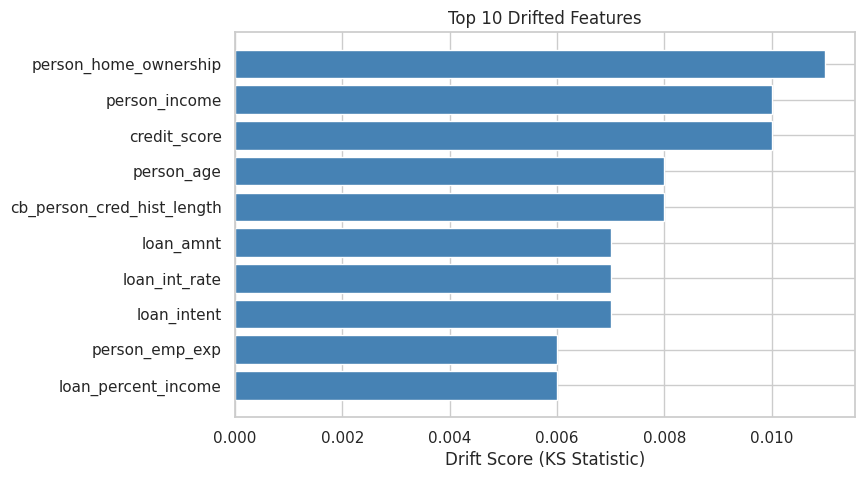

🔹 Average Drift Score: 0.007
🔹 Number of features with significant drift: 0/14


In [17]:
# 🟦 Step 3: Compute drift table
drift_df = calculate_drift(reference_df, current_df)

# 🟦 Step 4: Display drift results
display(drift_df.sort_values('ks_stat', ascending=False))

# 🟦 Step 5: Visualization — Top Drifted Features
top_drift = drift_df.sort_values('ks_stat', ascending=False).head(10)

plt.figure(figsize=(8,5))
plt.barh(top_drift['feature'], top_drift['ks_stat'], color='steelblue')
plt.xlabel('Drift Score (KS Statistic)')
plt.title('Top 10 Drifted Features')
plt.gca().invert_yaxis()
plt.show()

# 🟦 Step 6: Summary metric for presentation
avg_drift = drift_df['ks_stat'].mean()
high_drift_count = drift_df['drift_detected'].sum()

print(f"🔹 Average Drift Score: {avg_drift:.3f}")
print(f"🔹 Number of features with significant drift: {high_drift_count}/{len(drift_df)}")

**Column Transformer**

In [19]:
NUMERIC = [c for c in numeric_features if c in df_fe.columns]
CATEGORICAL = [c for c in categorical_features if c in df_fe.columns]

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, NUMERIC),
    ('cat', categorical_transformer, CATEGORICAL + ['age_bucket','credit_score_cat'] if 'age_bucket' in df_fe.columns else CATEGORICAL)
], remainder='drop')

**Pipeline**

In [20]:
# Build full pipeline with classifier
clf = RandomForestClassifier(n_estimators=200, random_state=42)
pipeline = Pipeline([('pre', preprocessor), ('clf', clf)])

# Prepare X,y from processed df_fe
X = df_fe[NUMERIC + CATEGORICAL + (['age_bucket','credit_score_cat'] if 'age_bucket' in df_fe.columns else [])]
y = df_fe['loan_status'].astype(int)

X_train, X_test_model, y_train, y_test_model = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# MLflow setup: local experiment
mlflow.set_experiment("loan_bias_drift_demo")

with mlflow.start_run() as run:
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test_model)
    probs = pipeline.predict_proba(X_test_model)[:,1]
    acc = accuracy_score(y_test_model, preds)
    auc = roc_auc_score(y_test_model, probs)
    print("Accuracy:", acc, "AUC:", auc)
    print(classification_report(y_test_model, preds))
    # log metrics & model
    mlflow.log_metric("accuracy", float(acc))
    mlflow.log_metric("roc_auc", float(auc))
    # log model as artifact (not full registry here; local artifact)
    model_path = "artifacts/model.joblib"
    os.makedirs("artifacts", exist_ok=True)
    joblib.dump(pipeline, model_path)
    mlflow.log_artifact(model_path, artifact_path="model")
    print("Model saved to", model_path)
    run_id = run.info.run_id

print("MLflow run id:", run_id)

2025/10/23 09:46:19 INFO mlflow.tracking.fluent: Experiment with name 'loan_bias_drift_demo' does not exist. Creating a new experiment.


Accuracy: 0.9263333333333333 AUC: 0.9732690714285714
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7000
           1       0.89      0.77      0.82      2000

    accuracy                           0.93      9000
   macro avg       0.91      0.87      0.89      9000
weighted avg       0.92      0.93      0.92      9000

Model saved to artifacts/model.joblib
MLflow run id: f2bf24e0443b4fa7b35908a6a6746c59
